Serie temporal con municipios de Murcia

In [1]:
!pip uninstall -y torch notebook notebook_shim tensorflow tensorflow-datasets prophet torchaudio torchdata torchtext torchvision
!pip install neuralprophet


Found existing installation: torch 2.3.0
Uninstalling torch-2.3.0:
  Successfully uninstalled torch-2.3.0
  Using cached torch-2.3.0-cp310-cp310-manylinux1_x86_64.whl (779.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.15 requires torchvision>=0.11, which is not installed.


In [2]:
import pandas as pd
from datetime import datetime, date

In [71]:
raw = pd.read_csv('datos_murcia.csv', sep=';', header=0, decimal=',')
raw.drop(columns=['Column1', 'reg_id', 'CDAD_ID', 'reg_ds', 'COMAU_DS',
                      'Medios_masivos_offline', 'Medios_masivos_online', 'Marketing_Directo',
                      'Street_Marketing', 'educacion_ambiental', 'UNGES_DS', 'tamano_municipio',
                      'kgs_recogidos tipo: Carga Lateral', 'kgs_recogidos tipo: Carga Trasera', 'kgs_recogidos tipo: Desconocido',
                      'kgs_recogidos tipo: Iglú', 'kgs_recogidos tipo: Sistema Neumática', 'kgs_recogidos tipo: Sistema Soterrado',
                      'kgs_recogidos tipo: Variable', 'recogida_gestion_tratamiento_residuos', 'consumo_nielsen', 'consumo_MWh', 'ratio_consumo_KWh_ccaa'], inplace=True)
raw.rename(columns={"DATE": 'ds'}, inplace=True)
raw.ds = pd.to_datetime(raw.ds, format='%d/%m/%Y %H:%M')
raw.ds = raw.ds.apply(lambda x: x.replace(hour=0, minute=0, second=0))
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ds                       1440 non-null   datetime64[ns]
 1   CODIGO_UNGES             1440 non-null   object        
 2   kgs_recogidos            1440 non-null   float64       
 3   poblacion                1440 non-null   int64         
 4   contenedores_total       1440 non-null   int64         
 5   ACCOMMODATION            1440 non-null   int64         
 6   CATERING                 1440 non-null   int64         
 7   HOSPITAL                 1440 non-null   int64         
 8   SHOPPING_MALL            1440 non-null   int64         
 9   SPORT                    1440 non-null   int64         
 10  SUPERMARKET              1440 non-null   int64         
 11  ADMINISTRACION           1440 non-null   int64         
 12  consumo_KWh              1440 non-

In [74]:
df = pd.DataFrame()
df['ds'] = raw.ds
df['kg'] = raw.kgs_recogidos
df['kg/hab'] = raw.kgs_recogidos / raw.poblacion
df['kWh/hab'] = raw.consumo_KWh / raw.poblacion
df['cons/hab'] = raw.consumo_nielsen_por_hab
df['conts/hab'] = raw.contenedores_total / raw.poblacion
df['coml/hab'] = (raw.ACCOMMODATION + raw.CATERING + raw.SHOPPING_MALL + raw.SUPERMARKET + raw.SPORT) / raw.poblacion
df['hab'] = raw.poblacion
df['UG'] = raw.CODIGO_UNGES
df['verano'] = raw.ds.apply(lambda x: 1 if x.month in [7, 8, 9] else 0)
df

ds        kg    kg/hab     kWh/hab  cons/hab  conts/hab  \
0    2021-06-01  156080.0  2.123595  450.732496    79.234   0.017538   
1    2020-11-01   50540.0  1.386025  465.435946    72.719   0.007432   
2    2020-11-01   27560.0  1.072874  291.809444    72.719   0.003971   
3    2020-10-01   57900.0  1.587867  455.385979    78.611   0.007432   
4    2020-10-01   29340.0  1.142168  281.767181    78.611   0.003971   
...         ...       ...       ...         ...       ...        ...   
1435 2021-09-01   47940.0  1.424877  456.229613    76.638   0.004815   
1436 2021-09-01  142580.0  1.939917  463.167138    76.638   0.017538   
1437 2021-09-01   32180.0  1.256491  302.861101    76.638   0.003983   
1438 2021-06-01   62880.0  1.685836  496.441022    79.234   0.007266   
1439 2021-06-01   45380.0  1.348789  449.268311    79.234   0.004815   

      coml/hab    hab      UG  verano  
0     0.003714  73498  UG1213       0  
1     0.011217  36464  UG1222       0  
2     0.005022  25688  UG1229       0  
3     0.011217  36464  UG1222       0  
4     0.005022  25688  UG1229       0  
...        ...    ...     ...     ...  
1435  0.007668  33645  UG1216       1  
1436  0.003714  73498  UG1213       1  
1437  0.005037  25611  UG1229       1  
1438  0.010965  37299  UG1222       0  
1439  0.007668  33645  UG1216       0  

[1440 rows x 10 columns]

In [75]:
df.loc[df.UG == 'UG1216'].sort_values(by='ds').reset_index()

index         ds       kg    kg/hab     kWh/hab  cons/hab  conts/hab  \
0     589 2018-01-01  18880.0  0.591757  438.675552    75.634   0.003981   
1     587 2018-02-01  16480.0  0.516533  394.630277    70.225   0.003981   
2     584 2018-03-01  20320.0  0.636891  408.839043    76.699   0.003981   
3     581 2018-04-01  21160.0  0.663219  398.959651    74.795   0.003981   
4     578 2018-05-01  25240.0  0.791099  406.207345    77.004   0.003981   
5     149 2018-06-01  30860.0  0.967247  473.770015    79.512   0.003981   
6     148 2018-07-01  49520.0  1.552108  695.645280    72.757   0.003981   
7     264 2018-08-01  82270.0  2.578593  723.553926    67.995   0.003981   
8     574 2018-09-01  34700.0  1.087604  481.110965    77.120   0.004451   
9      23 2018-10-01  27100.0  0.849397  401.089317    78.507   0.004451   
10     21 2018-11-01  23740.0  0.744084  375.645751    73.842   0.004451   
11    158 2018-12-01  23080.0  0.723398  416.486381    79.377   0.004451   
12    572 2019-01-01  19340.0  0.595278  430.790221    77.131   0.004371   
13     18 2019-02-01  20940.0  0.644526  387.536674    70.957   0.004371   
14     15 2019-03-01  24480.0  0.753486  401.490033    79.320   0.004371   
15    569 2019-04-01  31240.0  0.961556  391.788226    73.642   0.004371   
16    236 2019-05-01  29120.0  0.896303  398.905640    78.870   0.004371   
17    235 2019-06-01  34120.0  1.050202  465.253850    78.003   0.004679   
18    234 2019-07-01  66200.0  2.037613  683.140838    75.615   0.004679   
19    233 2019-08-01  86640.0  2.666749  710.547816    68.222   0.004679   
20    143 2019-09-01  41960.0  1.291514  472.462844    75.454   0.004679   
21    232 2019-10-01  35560.0  1.094524  393.879611    79.551   0.004679   
22    139 2019-11-01  29360.0  0.903690  368.893400    76.365   0.004679   
23    136 2019-12-01  26600.0  0.818739  408.999908    78.765   0.004679   
24    965 2020-01-01  23540.0  0.710556  422.468034    77.878   0.004588   
25    964 2020-02-01  23455.0  0.707990  380.050077    77.458   0.004588   
26    963 2020-03-01  28355.0  0.855897  393.733879    80.341   0.004588   
27    962 2020-04-01  31885.0  0.962450  384.219496    74.711   0.004588   
28   1090 2020-05-01  31600.0  0.953847  391.199412    80.630   0.004588   
29   1089 2020-06-01  38565.0  1.164086  456.265880    78.303   0.004588   
30    961 2020-07-01  66865.0  2.018322  669.943635    76.060   0.004588   
31    241 2020-08-01  82270.0  2.483323  696.821154    69.042   0.004890   
32   1202 2020-09-01  43405.0  1.310181  463.335607    78.288   0.004890   
33   1087 2020-10-01  33825.0  1.021009  386.270478    78.611   0.004890   
34   1085 2020-11-01  30080.0  0.907966  361.766962    72.719   0.004890   
35    960 2020-12-01  27670.0  0.835220  401.098675    79.819   0.004890   
36    550 2021-01-01  28660.0  0.851835  415.988810    77.672   0.004815   
37    548 2021-02-01  28600.0  0.850052  374.221400    71.572   0.004815   
38    261 2021-03-01  34780.0  1.033735  387.695339    81.361   0.004815   
39    545 2021-04-01  34720.0  1.031951  378.326874    78.309   0.004815   
40    543 2021-05-01  32860.0  0.976668  385.199742    78.511   0.004815   
41   1439 2021-06-01  45380.0  1.348789  449.268311    79.234   0.004815   
42    231 2021-07-01  75460.0  2.242830  659.668975    77.023   0.004815   
43    230 2021-08-01  87360.0  2.596523  686.134284    66.617   0.004815   
44   1435 2021-09-01  47940.0  1.424877  456.229613    76.638   0.004815   
45    540 2021-10-01  38900.0  1.156190  380.346401    80.075   0.004815   
46   1432 2021-11-01  33560.0  0.997474  356.218685    79.224   0.004815   
47    539 2021-12-01  30800.0  0.915441  394.947184    82.260   0.004815   
48    536 2022-01-01  27280.0  0.791459  406.056154    77.476   0.004555   
49    229 2022-02-01  27800.0  0.806545  365.286033    73.757   0.004555   
50    228 2022-03-01  33840.0  0.981780  378.438252    88.178   0.004555   
51    529 2022-04-01  40420.0  1.172682  369.293480 

In [6]:
!pip install plotly

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (6) is too small than the required number                     for the learning rate finder (204). The results might not be optimal.


Finding best initial lr:   0%|          | 0/204 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

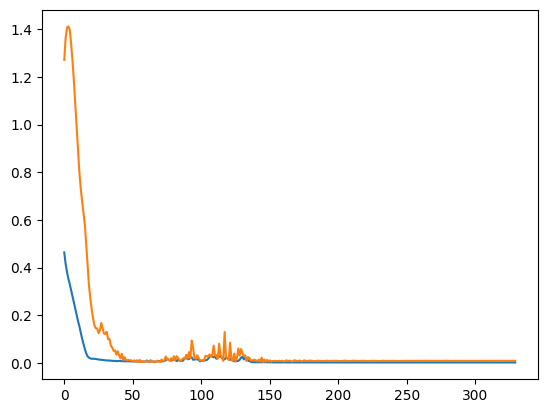

In [77]:
from neuralprophet import NeuralProphet, set_log_level
set_log_level("WARNING")
m = NeuralProphet()
m.add_future_regressor("verano")
m.add_future_regressor("kWh/hab")
m.add_future_regressor("cons/hab")
m.add_future_regressor("conts/hab")
m.add_future_regressor("coml/hab")
m.add_future_regressor("hab")

aux = df.loc[df.UG == 'UG1216', [
                                 'ds',
                                 'kg',
                                 'verano',
                                 'kWh/hab',
                                 'cons/hab',
                                 'conts/hab',
                                 'coml/hab',
                                 'hab',
                                 ]].rename(columns={'kg': 'y'}).sort_values(by='ds')
df_train, df_test = m.split_df(df=aux, freq="M", valid_p=0.2)
metrics = m.fit(df_train, validation_df=df_test, progress='plot')

Predicting: 6it [00:00, ?it/s]

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


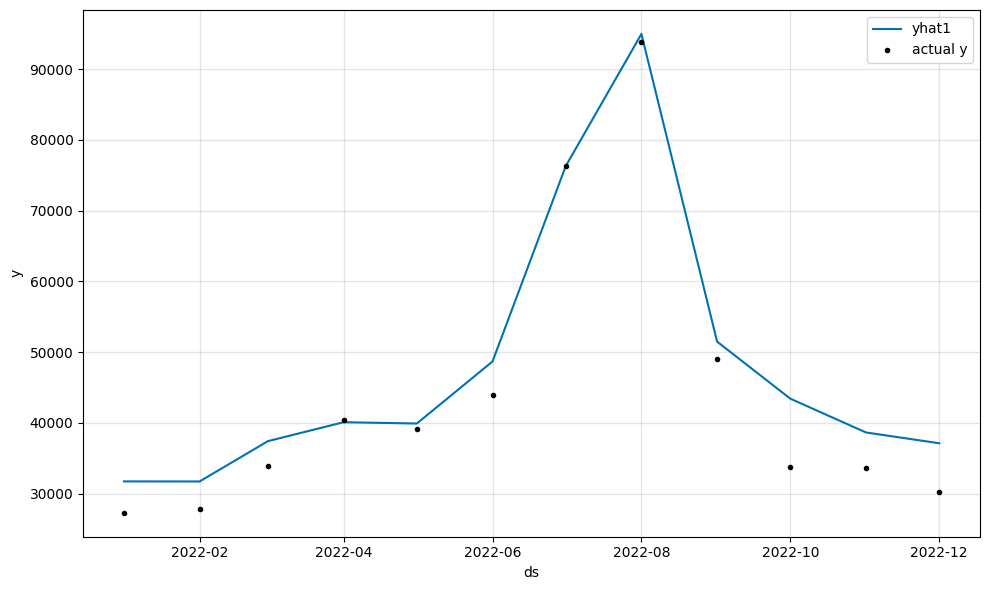

In [78]:
# df_future = m.make_future_dataframe(aux, n_historic_predictions=True, periods=24)
# Predict the future
forecast = m.predict(df_test)
m.set_plotting_backend("matplotlib")
# Visualize the forecast
m.plot(forecast)

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


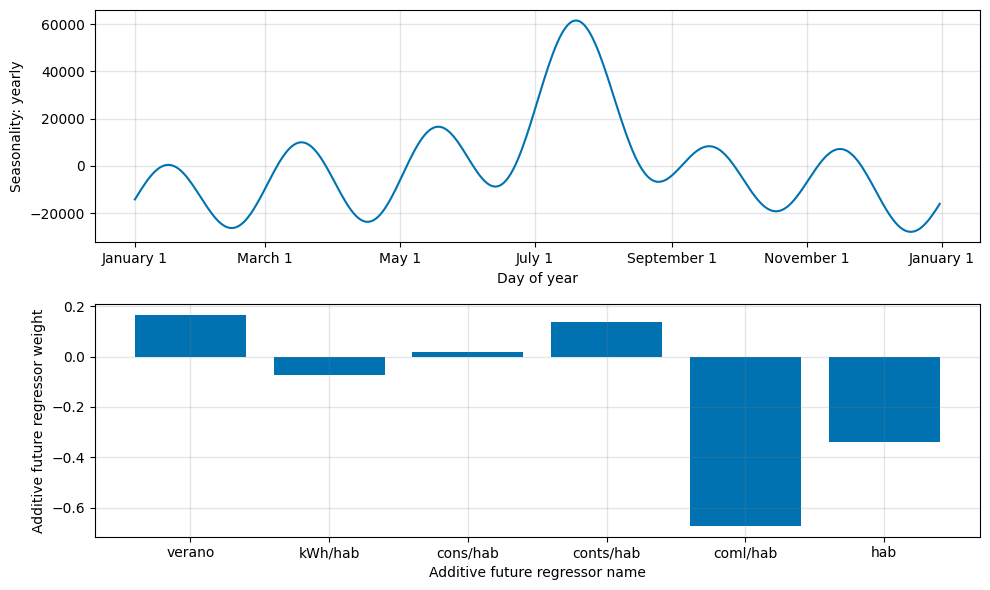

In [79]:
m.plot_parameters(components=["seasonality", 'future_regressors'])